## detect_particles.py

In [1]:
import sys
import matplotlib.pyplot as plt 
import numpy as np 
from tomo_encoders.misc_utils.feature_maps_vis import view_midplanes 
import cupy as cp 
import time 
import h5py 
#from recon_subvol import fbp_filter, recon_patch 

from tqdm import tqdm
from tomo_encoders import DataFile, Patches
import os 
from tomo_encoders.misc_utils.phantom_generators import get_sub_vols_elliptical_voids
from tomo_encoders.misc_utils.viewer import view_midplanes

### to-do:  
1. make everything with numpy
2. use cupy, what is performance again assuming array is on cpu first?

In [2]:
from scipy.ndimage import label as label_np
from scipy.ndimage import find_objects
def wrapper_label(vol_seg, n_max_detect, TIMEIT = False):
    '''
    takes in a big volume with zeros indicating voids and ones indicating material.  
    outputs labeled array with zero indicating material and labels [1, n_max_detect] indicating different voids.  
    if n_max_detect is smaller than the total number detected, the smaller voids are ignored and assigned values of background ( = 0)
    finally, array dtype is adjusted based on number of voids. e.g. if n_detected < 2**8 - 1, then array is uint8, etc.
    '''
    
    assert vol_seg.dtype == 'uint8', "vol_seg must be uint8"
    
    t0 = time.time()
    print("detecting all particles up to max possible integer precision")
    vol_lab, n_detected,  = label_np(vol_seg^1)
    s_voids = find_objects(vol_lab)
    print("found %i"%n_detected)
    
    # DEBUG ONLY
    assert len(s_voids) == n_detected, "find_objects test failed: detected number of slice objects does not match output from label"    
    
    print("finding objects and sorting by size (decreasing order)")
    p3d_voids = Patches(vol_lab.shape, initialize_by="slices", s = s_voids)
    # create feature array - ["void_id", "void_size"]
    void_features = np.zeros((len(s_voids), 2))
    for ip in range(len(s_voids)):
        void_id = ip + 1
        sub_vol = (vol_lab[s_voids[ip]] == void_id).astype(np.uint8)
        void_size = np.cbrt(np.sum(sub_vol))
        void_features[ip, 0] = void_id
        void_features[ip, 1] = void_size
    p3d_voids.add_features(void_features, names = ["void_id", "void_size"])    
    
    del s_voids
    # filter by size, "n" largest voids: hence ife = 0
    p3d_voids = p3d_voids.select_by_feature(n_max_detect, ife = 1, selection_by = "highest")
    s_voids = p3d_voids.slices()
    
    # sub_vols_voids_b should contain only those voids that the sub-volume is pointing to.
    # Need to ignore others occuring in the sub_vol by coincidence.
    sub_vols_voids = []
    for ip in range(len(p3d_voids)):
        sub_vols_voids.append((vol_lab[tuple(s_voids[ip,:])] == p3d_voids.features[ip,0]).astype(np.uint8))

    t1 = time.time()
    t_tot = t1 - t0
    if TIMEIT:
        print("TIME for counting voids: %.2f seconds"%t_tot)
        
    return sub_vols_voids, p3d_voids


### ('b' stands for binned = detector binning): e.g., vol_seg_b, sub_vols_voids_b, p3d_voids_b

In [3]:
vol_shape = (1000,1000,1000)
VOL_B_SHAPE = (1000,1000,1000)

In [4]:
vol_seg_b = np.ones(vol_shape, dtype = np.uint8)
patch_size = (32,32,32)
n_voids_gt = 3000 #len(p)
n_max_detect = 300

## Create voids in sub-volumes and assign to output volume  

In [5]:
p = Patches(vol_shape, \
            initialize_by = 'regular-grid', \
            patch_size = patch_size, \
            stride = 1, \
            n_points = n_voids_gt)
y = get_sub_vols_elliptical_voids(patch_size, len(p), ellipse_range = (1.5, 1.8), rad_range = (5,8))
p.fill_patches_in_volume(y, vol_seg_b, TIMEIT = True)

TIME PER UNIT PATCH fill_patches_in_volume: 0.02 ms


Text(0, 0.5, 'void size')

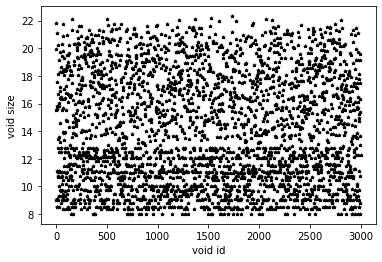

In [6]:
void_size_gt = np.cbrt(np.prod(patch_size) - np.sum(y, axis = (1,2,3)))
plt.scatter(np.arange(len(p)), void_size_gt, marker ='*', color = 'black', s = 10)
plt.xlabel("void id")
plt.ylabel("void size")

**Comments** The void size is defined as ${{volume}^{1/3}}$ where the volume of each void is counted as the sum of voxels inside the void. In above figure, the distribution of void size in the randomly generated elliptical voids is shown. Note that the patches are NOT sorted by size. So when these are assigned on a grid inside the big volume *vol_seg_b*, they are assigned to random locations.  

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

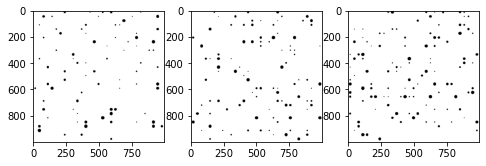

In [7]:
fig, ax = plt.subplots(1,3, figsize = (8,4))
view_midplanes(vol_seg_b, ax = ax)

## Test wrapper for label()  - connected components    

In [8]:
sub_vols_voids_b, p3d_voids_b = wrapper_label(vol_seg_b, n_max_detect, TIMEIT = False)

detecting all particles up to max possible integer precision
found 3000
finding objects and sorting by size (decreasing order)


In [9]:
assert len(p3d_voids_b) <= n_max_detect, "test failed: number of detected particles is greater than the maximum requested."
# assert n_detected == n_voids_gt, "test failed: number of detected particles is not equal to the ground-truth."

### Assert if labels are sorted by size automatically

Text(0, 0.5, 'void size')

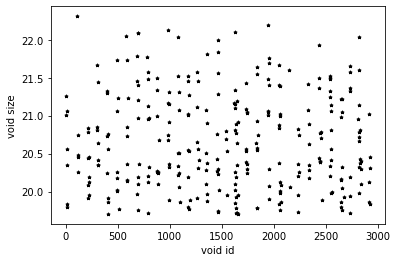

In [10]:
plt.scatter(p3d_voids_b.features[:,0], p3d_voids_b.features[:,1], marker ='*', color = 'black', s = 10)
plt.xlabel("void id")
plt.ylabel("void size")

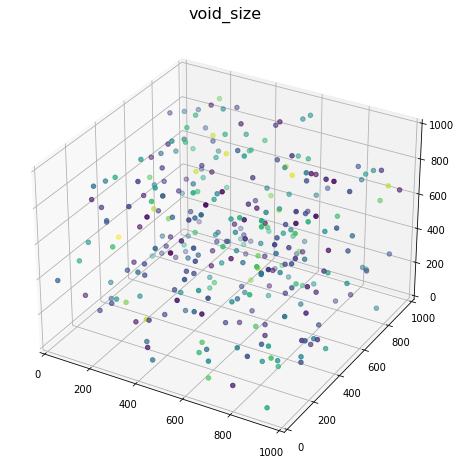

In [11]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
p3d_voids_b.plot_3D_feature(1, ax)

In [12]:
# check that p3d_voids and sub_vols are sorted, by checking the size
for ii in range(len(sub_vols_voids_b)):
    assert np.cbrt(np.sum(sub_vols_voids_b[ii])) == p3d_voids_b.features[ii,1], "voids sub_vol and p3d_voids do not match at %i"%ii

## get_patches_on_grid()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

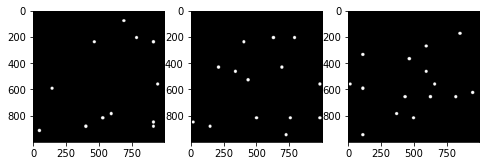

In [13]:
# fill patches and resize
vol_lab_b = np.empty(vol_seg_b.shape, dtype = np.uint8)
p3d_voids_b.fill_patches_in_volume(sub_vols_voids_b, vol_lab_b)
fig, ax = plt.subplots(1,3, figsize = (8,4))
view_midplanes(vol_lab_b > 0, ax = ax)

In [14]:
def to_regular_grid(sub_vols, p3d, patch_size, upsample_value = 1):
    '''
    (1) select patches where voids exist (2) rescale to upsample_value
    '''
    # make vol_seg_b
    vol = np.empty(p3d.vol_shape, dtype = sub_vols[0].dtype)
    p3d.fill_patches_in_volume(sub_vols, vol)    
    assert vol.max() == 1, "vol is not binary, which is required for the selection criteria"

    
    p3d_grid = Patches(p3d.vol_shape, initialize_by="regular-grid", patch_size = patch_size, stride = 1)
    y = p3d_grid.extract(vol, patch_size)
    contains_voids = np.sum(y, axis = (1,2,3)) > 0
    # select voids (voids are considered particles here (== 1))
    p3d_grid = p3d_grid.select_by_condition(contains_voids)
    # to-do need to upsample !!
    
    return

In [17]:
sub_vols_voids_b[0].shape

(29, 27, 27)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

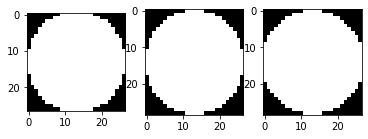

In [21]:
view_midplanes(sub_vols_voids_b[0])

In [15]:
# ip = 10
# sub_vol = vol_lab_b[s_voids[ip]]
# np.cbrt(np.sum(sub_vol == ip + 1)) == p3d_voids.features[ip,1], "size calculation error"
# print("void size %i"%p3d_voids.features[ip,1])
# print("void   id %i"%p3d_voids.features[ip,0])
# view_midplanes(sub_vol == ip + 1)